# MountainCar by Q-learning 

Solving the MountainCar Problem using discrete Q-learning method

In [27]:
import time
import gym
import numpy as np
import matplotlib.pyplot as plt   
import torch
import torch.nn as nn

class Q_LEARN:
    def __init__(self, env):
        self.env      = env                                     # environment we work with                        
        self.plot_episodes = 100                                # show result each 
        self.stat_episodes = 1000                               # smoothing statistic
        self.history       = []
        
        self.CFG = {
            'method' : "Q-learning",
            'actions': [0, 2],     # list of actions
            'bins'   : (101, 101), # splittings of axes
            'gamma'  : 1,       # discount rate
            'eps1'   : 1.0,        # start epsilon
            'eps2'   : 0.01,      # finish epsilon before 0
            'decays' : 0,      # epochs of decay            
            'lm'     : 0.1,        # learning rate
        }

    #---------------------------------------------------------------------------------------
    
    def init(self):
        self.bins    = self.CFG['bins']                      # number of intervals along each axis
        self.actions = self.CFG['actions']                   # list of actions number
        
        self.obs_min = self.env.observation_space.low           # minimum observation values
        self.obs_max = self.env.observation_space.high          # maximum observation values
        self.obs_win = (self.obs_max-self.obs_min)/self.bins    # interval widths
        
        self.epsilon = self.CFG['eps1']                      # random policy probability
        self.decay   = 0
        if self.CFG['eps1'] > 0 and self.CFG['decays'] > 0:
            self.decay   = np.exp(np.log(self.CFG['eps2']/self.CFG['eps1'])/self.CFG['decays'])
        
        print(self.CFG)        
        
    #---------------------------------------------------------------------------------------
    
    def init_Q(self, low=-2, high=0):
        """ set the initial values of the matrix Q  """                            
        self.Q = np.zeros( self.bins + (len(self.actions),) )
        self.N = np.zeros( self.bins + (len(self.actions),) )
        
        self.best_reward = -1e10
        self.best_Q      = None
    
    #---------------------------------------------------------------------------------------
    
    def policy(self, state):           
        """ return action in the state  """
        if np.random.random() < self.epsilon:                  # random action
            return np.random.randint(len(self.actions))            
        
        return np.argmax(self.Q[state])                        # best action from the table            
    
    #---------------------------------------------------------------------------------------
                
    def index(self, state):
        """ return numbers on a discrete grid for the state """
        indx = (state - self.obs_min) / self.obs_win
        indx = indx.clip(np.zeros_like(self.obs_min), np.array(self.bins)-1)
        return tuple( indx.astype(int) )                
    
    #---------------------------------------------------------------------------------------

    def smooth(self, Q):
        """ smooth Q-function """
        pool = nn.AvgPool2d(3, stride=1, padding = 1, count_include_pad=False)
        return pool(torch.tensor(Q).permute(2,0,1)).permute(1,2,0).numpy()     
    
    #---------------------------------------------------------------------------------------
    
    def run_episode(self, episode, ticks, Qs):
        s0 = self.index( self.env.reset() )
        tot_rew = 0
        for t in range(ticks):
            a = self.policy(s0)                
            obs, rew, done, _ = self.env.step( self.actions[a] )  
            s = self.index(obs)
            tot_rew += rew
                
            maxQ = np.max(self.Q[s]) # if not done or t == ticks-1 else 0                 
                
            TD = rew + self.CFG['gamma'] * maxQ - self.Q[s0+(a,)]                            
            self.Q[s0 + (a,)] = self.Q[s0 + (a,)] + self.CFG['lm']*TD  
            self.N[s0 + (a,)] += 1
                
            Qs.append(maxQ)
                
            if done:
                break
                    
            s0 = s
               
            
        return tot_rew
    
    #---------------------------------------------------------------------------------------
    
    def learn(self, episodes = 100000, ticks = 200, smoothing = None, draw = None):
        """ Q-learning """
        rews, Qs = [], []
        for episode in range(1, episodes+1):        
            tot_rew = self.run_episode(episode, ticks, Qs)
            
            self.epsilon *= self.decay                             # epsilon decay
            if self.epsilon < self.CFG['eps2']:
                self.epsilon = 0
                
            rews.append(tot_rew)
            
            if draw or episode % self.plot_episodes == 0:              
                mean, std, mi, ma = np.mean(rews[-self.stat_episodes:]), np.std(rews[-self.stat_episodes:]), np.min(rews[-self.stat_episodes:]),  np.max(rews[-self.stat_episodes:])
                meanQ,stdQ = np.mean(Qs[-self.stat_episodes:]),  np.std(Qs[-self.stat_episodes:])
                short = np.mean(rews[-self.plot_episodes:])
                self.history.append([episode, short, mean])
                if mean > self.best_reward:
                    self.best_reward = mean
                    self.best_Q = np.copy(self.Q)
                
                print(f"\r{episode:7d} Reward: {mean:7.2f} ± {std/self.stat_episodes**0.5:3.1f} [{mi:4.0f}, {ma:4.0f}] best: {self.best_reward:7.1f};  epsilon: {self.epsilon:.3f}, Q: {meanQ:6.2f} ± {stdQ:6.2f}", end="")                

            if smoothing and episode and episode % smoothing == 0:
                self.Q = self.smooth(self.Q)
                
            if episode <= 10 or (episode > 10 and episode <= 1000 and episode % 10 == 0) or (episode > 1000 and episode % 100 == 0):
                draw(f"V-function episode:{episode:6d}  reward: {mean:4.0f}  [{mi:4.0f}, {ma:4.0f}]   (с) QuData.com")         
                             
    #---------------------------------------------------------------------------------------
    
    def test(self, episodes = 1000, ticks = 1000):
        """ Тестирование с неизменной Q-функцией """
        rews = []
        for _ in range(episodes):        
            obs =  self.env.reset()
            tot = 0
            for _ in range(ticks):
                s = self.index(obs)
                a = self.policy(s)                
                obs, rew, done, _ = self.env.step( self.actions[a] )

                tot += rew
                if done:                    
                    break
            rews.append(tot)
            
        print(f"Reward: {np.mean(rews):7.2f} ± {np.std(rews)/len(rews)**0.5:.1f} [{np.min(rews)}, {np.max(rews)}]")
        
model = Q_LEARN(gym.make("MountainCar-v0"))


## Run learning

In [19]:
model.init()
model.init_Q()
print(model.Q.shape)
beg  = time.process_time()
model.learn(episodes = 100000, smoothing = None)
print(f"time: {(time.process_time()- beg)/60:.2f} min")
model.test()

{'method': 'Q-learning', 'actions': [0, 2], 'bins': (101, 101), 'gamma': 1, 'eps1': 1.0, 'eps2': 0.01, 'decays': 0, 'lm': 0.1}
(101, 101, 2)
 100000 Reward: -110.79 ± 0.8 [-193,  -84] best:  -109.4;  epsilon: 0.000, Q: -50.24 ±  29.19time: 11.38 min
Reward: -110.47 ± 0.8 [-186.0, -84.0]


<Figure size 864x720 with 0 Axes>

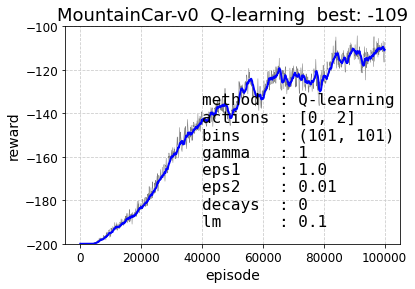

In [20]:
cfg = [ f"{k:8s}: {v}\n" for k,v in model.CFG.items()]
data = np.array(model.history)
plt.figure(figsize=(12,10))   
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 12})
plt.ylim(-200, -100)
plt.title(f"MountainCar-v0  Q-learning  best: {model.best_reward:4.0f}", fontsize=18)
plt.grid(color='#CCCCCC', linestyle='--')
plt.plot  (data[:,0], data[:,1], linewidth=0.5, color="gray")
plt.plot  (data[:,0], data[:,2], linewidth=2,   color="blue")
plt.xlabel('episode', fontsize=14);  plt.ylabel('reward', fontsize=14);
plt.text(40000, -200, "".join(cfg), {'fontsize':16, 'fontname':'monospace'})
plt.show()

## Smoothing the Q-function

In [95]:
model.Q = model.smooth(model.Q)

In [99]:
model.test(episodes = 10000)

Reward:  -99.63 ± 0.1 [-200.0, -83.0]


## Policy function

- Gray color - areas in which the agent during Monte Carlo wandering never got.
- In other cases: blue (action=0), white (action=1), red (action=2)

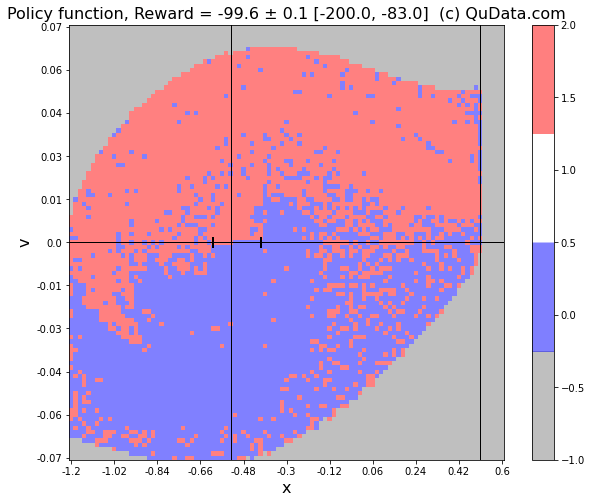

In [18]:
def plot(mat, title, d_ticks = 10, smooth = True):
    import math
    from matplotlib import colors
    if smooth:
        cmap = 'seismic'
    else:
        cmap = colors.ListedColormap(['gray', 'blue', 'white', 'red'])

    g, m   = model.index([0.5, 0.]), model.index([-math.pi/6, 0.])
    x1, x2 = model.index([-0.6, 0.]), model.index([-0.4, 0.])
    
    plt.figure(figsize=(10,8))    
    plt.imshow(mat.T, origin='lower', cmap=cmap, alpha=0.5)  

    plt.title (title, {'fontsize': 16})
    plt.xlabel('x', {'fontsize': 16}) 
    plt.ylabel('v', {'fontsize': 16}) 

    plt.axhline(g[1],  c="black", linewidth=1)
    plt.axvline(g[0],  c="black", linewidth=1)
    plt.axvline(m[0],  c="black", linewidth=1)
    plt.axvline(x1[0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    plt.axvline(x2[0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    
    binX, binV = range(0, model.bins[0], d_ticks), range(0, model.bins[1], d_ticks)
    plt.xticks( binX, np.round(100*np.linspace(model.obs_min[0], model.obs_max[0], len(binX)))/100 )
    plt.yticks( binV, np.round(100*np.linspace(model.obs_min[1], model.obs_max[1], len(binV)))/100 )    
    plt.colorbar() 
    plt.show()

pi = np.argmax(model.Q, axis=2)
if len(model.actions) == 2:
    pi = pi*2
pi[np.sum(model.N, 2) == 0] = -1
    
plot(pi, "Policy function, Reward = -99.6 ± 0.1 [-200.0, -83.0]  (с) QuData.com", smooth=False)

In [198]:
np.save("MountainCar_Q_51_2.100", model.Q)

In [48]:
model.Q = np.load("MountainCar_Q_51_2.100.npy")

## Value function

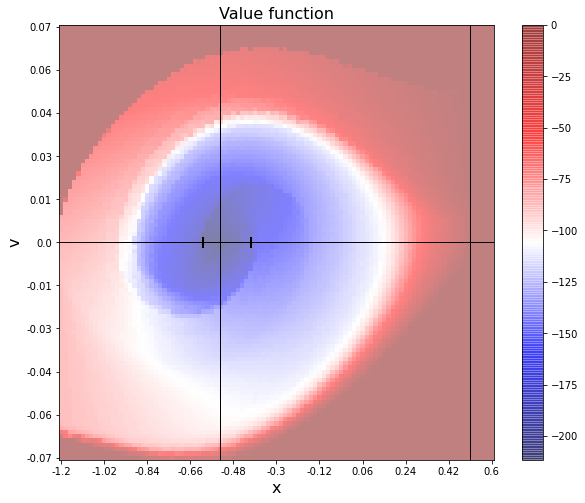

In [14]:
V = np.max(model.Q, axis=2)
if len(model.actions) == 2:
    V = V*2
V[np.sum(model.N, 2) == 0] = -1

plot(V, "Value function")

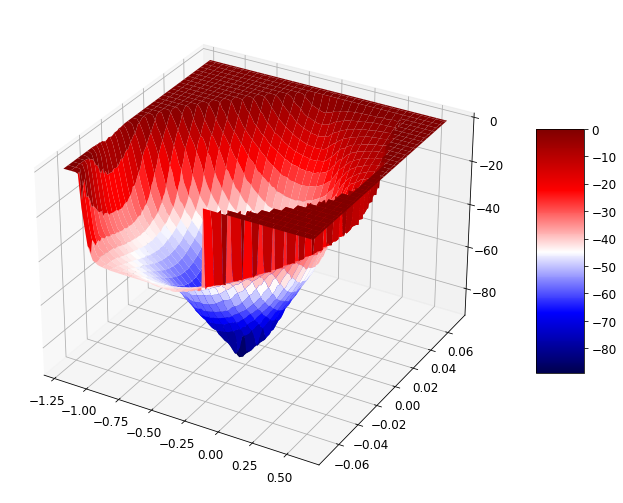

In [36]:
X = np.linspace(model.obs_min[0], model.obs_max[0], model.bins[0])
Y = np.linspace(model.obs_min[1], model.obs_max[1], model.bins[1])
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

surf = ax.plot_surface(X, Y, np.max(model.Q, axis=2), cmap=plt.get_cmap('seismic'), linewidth=0, antialiased=True)
#ax.view_init(-110, 60)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Animation V-function

In [28]:
import imageio
import math 
import io

frames = []

def plt_to_array(fig):
    """ Get array from figure of plt """
    buf = io.BytesIO()
    fig.savefig(buf, format='raw', dpi = 128)
    buf.seek(0)
    arr = np.reshape(np.frombuffer(buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    buf.close()    
    return arr


def draw(text):
    fig = plt.figure(figsize=(10,8), dpi = 128)        
    plt.title(text)
    #pi = np.argmax(model.Q, axis=2)
    V = np.max(model.Q, axis=2)    
    plt.imshow(V.T, origin='lower', cmap='seismic', vmax=0, vmin=-100)  


    #plt.title (title, {'fontsize': 16})
    plt.xlabel('x', {'fontsize': 16}) 
    plt.ylabel('v', {'fontsize': 16}) 

    g, m   = model.index([0.5, 0.]), model.index([-math.pi/6, 0.])
    x1, x2 = model.index([-0.6, 0.]), model.index([-0.4, 0.])    
    d_ticks = 10
    
    plt.axhline(g[1],  c="black", linewidth=1)
    plt.axvline(g[0],  c="black", linewidth=1)
    plt.axvline(m[0],  c="black", linewidth=1)
    plt.axvline(x1[0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    plt.axvline(x2[0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    
    binX, binV = range(0, model.bins[0], d_ticks), range(0, model.bins[1], d_ticks)
    plt.xticks( binX, np.round(100*np.linspace(model.obs_min[0], model.obs_max[0], len(binX)))/100 )
    plt.yticks( binV, np.round(100*np.linspace(model.obs_min[1], model.obs_max[1], len(binV)))/100 )    
    plt.colorbar() 
    
    frames.append( plt_to_array(fig) )
    plt.close() 
    
model.eps = 0
model.init()
model.init_Q()
print(model.Q.shape)


out = model.learn(episodes = 100000, draw = draw)
print("\nframes:", len(frames))
imageio.mimwrite("Q-learning.mp4", frames, fps=30)


{'method': 'Q-learning', 'actions': [0, 2], 'bins': (101, 101), 'gamma': 1, 'eps1': 1.0, 'eps2': 0.01, 'decays': 0, 'lm': 0.1}
(101, 101, 2)
 100000 Reward: -112.66 ± 0.8 [-179,  -84] best:  -107.0;  epsilon: 0.000, Q: -48.46 ±  26.63
frames: 1099


In [23]:
100000/100

1000.0